Title: 3.2 Project Milestone 2

Author: Chad Wood

Date: 4 Apr 2022

Modified By: Chad Wood

Description: This program demonstrates EDA on the spatial data I will be using for my term project. The projects goal is to propose a novel solution to the traveling salesman problem using reinforcement learning.

#### Introduction

I will be testing a novel solution to the traveling salesman problem. Reinforcement learning will be applied to the task of finding the most efficient route between multiple locations. 

    Allow for:
        n = Total Number of Locations
        P(n) = Total Number of Permutations (Without Repetition) of Locations

Due to <i>P(n)</i> growing exponentially as <i>n</i> grows linearly, many traditional computers cannot handle the task of finding the most efficient route using conventional means (i.e., calculating the parameters for each permutation). This becomes the case at a relatively low number when compared to the amount of mail distributed daily within each US city. In fact, P(75) has more permutations than the largest estimation of atoms within the observable universe (2.4809140811395E+109 versus 10E+82, respectively). 

One solution to this problem (implemented by UPS) is to cluster the locations into groups of five and calculate the quickest route for each cluster, then clustering the clusters by the same manner and calculating the quickest route between them. This will continue until the total amount of combined clusters is less than or equal to five, and finally they are all combined. This approach minimizes the number of calculations necessary to find a suitable route, though it does not find the most efficient route. As a consequence of clustering locations, this algorithm fails to account for the possibility of more efficient routes that travel outside the boundaries set by the lowest-level clusters.

As a novel solution to this problem, I will be applying the capabilities of reinforcement learning. This approach is suitable to the problem because there is a lack of real-world training data to support most supervised training methodologies. For this milestone, I will be performing EDA on the data I will be using to complete this task. 

To guide the EDA process, I've referenced the provided criteria below:

    Answer the questions from the text:

    What types of variables are there in the dataset?
    What do their distributions look like?
    Do you have missing values?
    Are there redundant features?
    What are the relationships between the main features?
    Do you observe outliers?
    How do the different pairs of features correlate with one another?
    Do these correlations make sense?
    What is the relationship between the features and the target?
    Have you confirmed or rejected your hypothesis?
    What do you know now that will inform the modeling strategy?

    You should have descriptive (e.g., test descriptions, descriptive statistics) and visual representations as part of your EDA deliverable

##### Deliverables


The data is downloaded in Protocolbuffer Binary Format (PBF) from Geofabrik, a distributor of OpenStreetMap data.
Data is available for several modes of travel, to include walking and driving, of which I've specified driving data.
The data I've selected is vector geographic information system data on the drivable roads within the state of Nevada. 
The digital representation of each road is referred to as a 'way'. I will use these data to calculate the distance, time, 
and cost between locations. Data remaining to be collected is gas station locations and sample addresses.



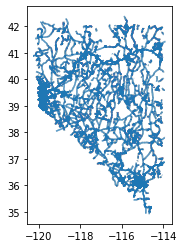

In [15]:
from pyrosm import OSM
from pyrosm import get_data

# Data Location: https://download.geofabrik.de/north-america/us/nevada.html
location = get_data("nevada")

# Initialize OSM parser
osm = OSM(location)

# Read drivable roads
drive_net = osm.get_network(network_type="driving")
drive_net.plot()

# Describe data
print('''
The data is downloaded in Protocolbuffer Binary Format (PBF) from Geofabrik, a distributor of OpenStreetMap data.
Data is available for several modes of travel, to include walking and driving, of which I've specified driving data.
The data I've selected is vector geographic information system data on the drivable roads within the state of Nevada. 
The digital representation of each road is referred to as a 'way'. I will use these data to calculate the distance, time, 
and cost between locations. Data remaining to be collected is gas station locations and sample addresses.
''')

Where available, the data describes each way with details such as the number of lanes, type of access, max speed-limit, ect. 
While it is true that much of this data is missing, this does not impact the project very much. Max speed-limit for each way
will be necessary, and one potential (though untested) avenue to fill this data is via the Google Maps API. Alternatively, 
I can try using a different city with more complete data.

Geographic spatial data is available for each way (inherently), and that is what will prove most valuable from this data.
Due to the inherent properties of this type of data; distributions and outliers and coorelations are likely not going to exist 
in a meaningful way. The data's purpose here is to provide the spatial information pertaining to each way that can contribute to
the models output (the most efficient route). This spacial data is provided via the length and geometry columns in full.

In [96]:
drive_net.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 217750 entries, 0 to 217749
Data columns (total 36 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   access          24444 non-null   object  
 1   area            30 non-null      object  
 2   bicycle         8453 non-null    object  
 3   bridge          2261 non-null    object  
 4   cycleway        3735 non-null    object  
 5   foot            4919 non-null    object  
 6   footway         1 non-null       object  
 7   highway         217750 non-null  object  
 8   junction        762 non-null     object  
 9   lanes           28969 non-null   object  
 10  lit             694 non-null     object  
 11  maxspeed        16990 non-null   object  
 12  motorroad       382 non-null     object  
 13  motor_vehicle   1741 non-null    object  
 14  name            97210 non-null   object  
 15  oneway          46075 non-null   object  
 16  overtaking      101 non-null  

The relationship between the variables length and geometry is a correlation, since geometry is a multilinestring 
representation of the road and the length describes a quantitative attribute of the road's size. Below are the given lengths of rows 195:200, along with the calculated length using the multilinestring found in column 
'geography'.

In [95]:
# Creates example dataframe comparing calculated vs given length of ways
examp = pd.DataFrame([list(drive_net['length'].iloc[195:200]), # Given length
                      list(drive_net['geometry'].iloc[195:200].to_crs(epsg=4087).length) # Calculated Length
                     ]).T 

examp.columns = ['Given', 'Calculated']
examp

,Given,Calculated
0,309.0,309.963945
1,144.0,144.262566
2,111.0,137.265780
3,40.0,40.357154
4,338.0,387.745710


Each way can also be visualized individually, which pandas can handle automatically after selecting the geometry object. 
The ability to select an individual way is crutial towards being able to apply this data to build a working enviroment for the
reinforcement learning model.

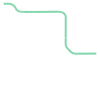

In [94]:
drive_net['geometry'].iloc[199]

#### Summary

After performing the EDA process, I now understand that I won't be able to rely on solely this data for speed-limits. However, the data should be functional for describing possible routes between locations. I've also discovered that the provided length is rounded, and therefore slightly less accurate than calculated length. I will very likely use calculated lengths opposed to given lengths. Because the data is vector GIS data, I am not too worried about its distribution. However, as I continue to explore sources for gas station locations and sample addresses, I may find that this changes. Though I have only a high-level understanding for reinforcement models, with no experience buildng one, I have an idea for how I believe the model will train. The model should work out different paths using the ways, making a decision at every intersection, and will be rewarded based on overall travel time and cost in gas. 